# Multivariate Stock Analysis using Gated Recurrent Unit (GRU), Long Short Term Memory and SimpleRNN

In [240]:

# Making a future prediction using "reference_days" past values
reference_days = 150
# Learning rate
learning_rate = 0.001 
# Choosing the type of layer to use in the model (GRU, LSTM or SimpleRNN in "create_tsa_model()" function)
layer_type = 'GRU' 
# Batch Size
batch_size = 32
# Epochs
epochs = 100

## Singlevariate Stock Prediction

In [241]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path
import pandas as pd

In [242]:
path = Path(r'TSLA.csv')
df = pd.read_csv(path,
                 parse_dates= True, 
                 index_col= "Date")

In [243]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


In [244]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


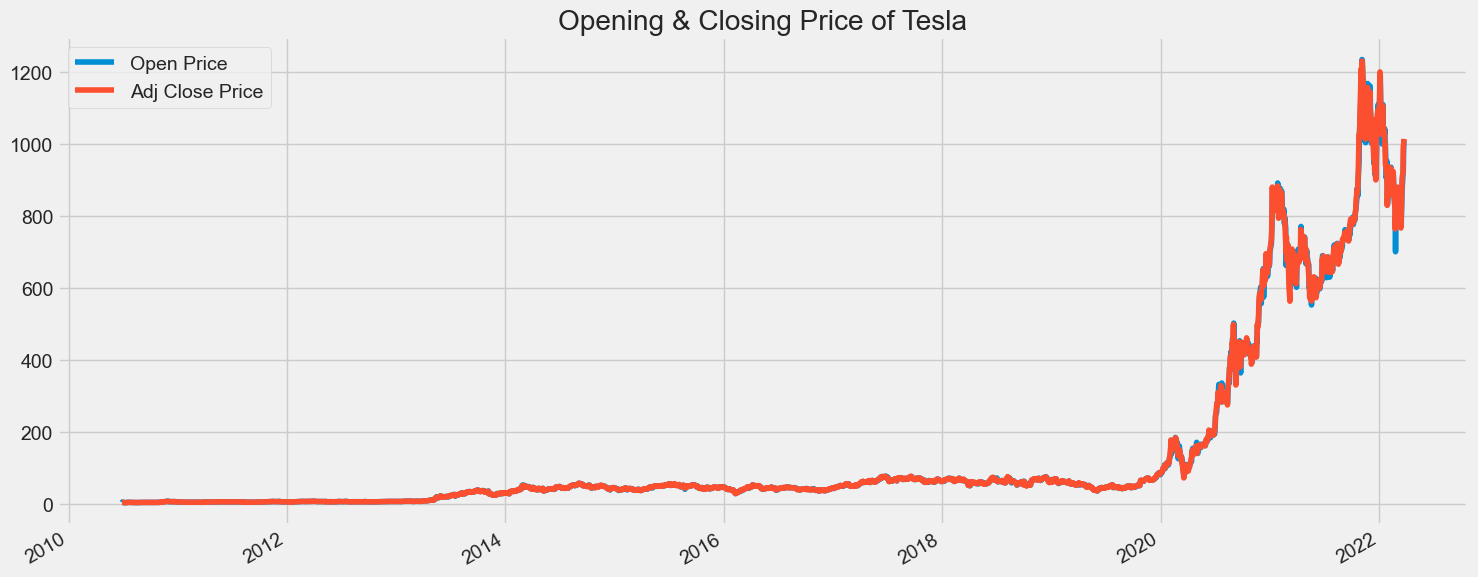

In [245]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Adj Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of Tesla")
plt.legend(['Open Price', 'Adj Close Price'])
plt.tight_layout()
plt.show()

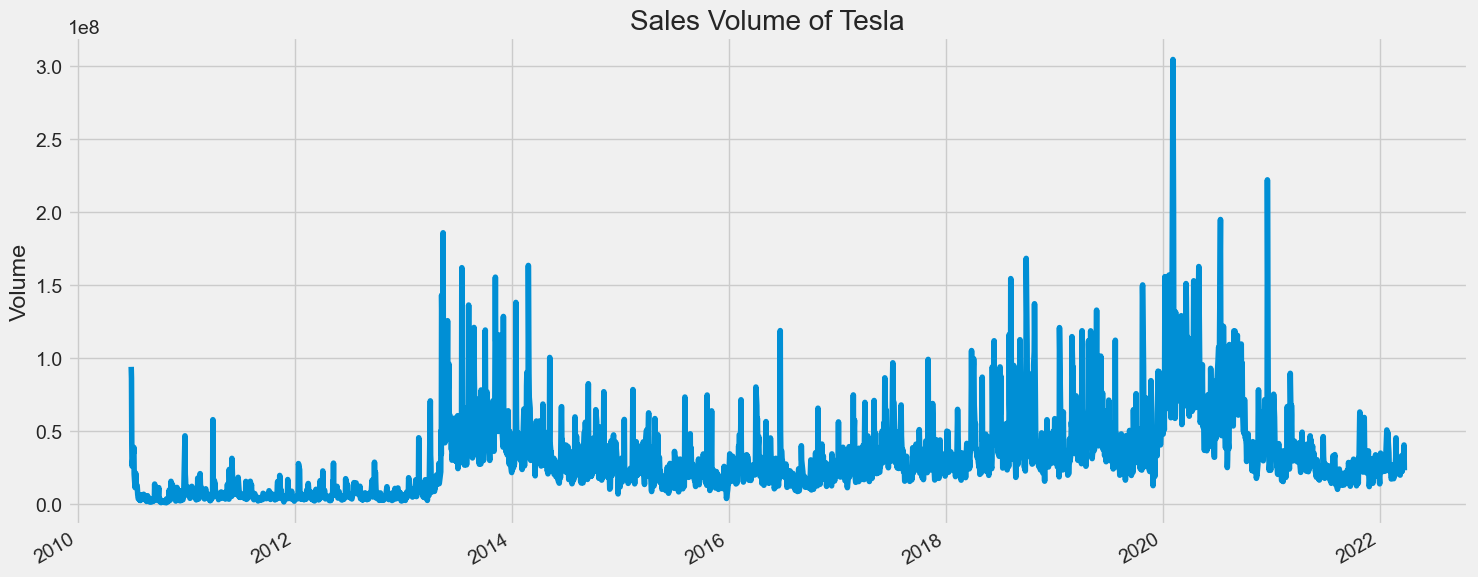

In [246]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

In [247]:
dataset = df["Adj Close"]
dataset = pd.DataFrame(dataset)

data = dataset.values
data.shape

(2956, 1)

In [248]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [249]:
# Determining the Training and Testing sizes: 75% and 25% respectively
train_size = int(len(data)*0.65)
val_size = int(len(data)*0.15)
test_size = len(data) - train_size - val_size

print("Train Size :",train_size,"Val Size :",val_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
val_data = scaled_data[ train_size - reference_days :train_size + val_size , 0:1 ]
test_data = scaled_data[ train_size + val_size - reference_days: , 0:1 ]

Train Size : 1921 Val Size : 443 Test Size : 592


In [250]:
# Creating a Training set with reference_days time-steps and 1 output
x_train = []
y_train = []
x_val = []
y_val = []
for i in range(reference_days, len(train_data)):
    x_train.append(train_data[i-reference_days:i, 0])
    y_train.append(train_data[i, 0])
for i in range(reference_days, len(val_data)):
    x_val.append(val_data[i-reference_days:i, 0])
    y_val.append(val_data[i, 0])

In [251]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

print(x_train.shape , y_train.shape)
print(x_val.shape , y_val.shape)

(1771, 150, 1) (1771,)
(443, 150, 1) (443,)


In [252]:
def create_tsa_model(layer_type = 'LSTM', 
                     learning_rate = 0.01, 
                     firstlayer_numberofneurons = 50, 
                     secondlayer_numberofneurons = 64, 
                     denselayer_numberofneurons = 32):

    if layer_type == 'LSTM':
        model = Sequential([
        LSTM(firstlayer_numberofneurons, return_sequences= True, input_shape= (x_train.shape[1], 1)),
        LSTM(secondlayer_numberofneurons, return_sequences= False),
        Dense(denselayer_numberofneurons),
        Dense(1)
    ])
    if layer_type == 'GRU':
        model = Sequential([
        GRU(firstlayer_numberofneurons, return_sequences= True, input_shape= (x_train.shape[1], 1)),
        GRU(secondlayer_numberofneurons, return_sequences= False),
        Dense(denselayer_numberofneurons),
        Dense(1)
    ])
    if layer_type == 'SimpleRNN':
        model = Sequential([
        SimpleRNN(firstlayer_numberofneurons, return_sequences= True, input_shape= (x_train.shape[1], 1)),
        SimpleRNN(secondlayer_numberofneurons, return_sequences= False),
        Dense(denselayer_numberofneurons),
        Dense(1)
    ])
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss= 'mse' , metrics= "mean_absolute_error", optimizer=opt)
    
    model_name = f'Singlevariate_{layer_type}_model_lr{learning_rate}_bs{batch_size}_window_{reference_days}'
    return model_name, model

In [253]:
model_name, model = create_tsa_model(layer_type = layer_type, learning_rate = learning_rate, firstlayer_numberofneurons = 50, secondlayer_numberofneurons = 64, denselayer_numberofneurons = 32)

In [254]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 150, 50)           10400     
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 41,953
Trainable params: 41,953
Non-trainable params: 0
_________________________________________________________________


In [255]:
# Fitting the model to the Training set
callbacks = [EarlyStopping(monitor= 'val_loss', patience= 3 , restore_best_weights= True)]
history = model.fit(x_train, 
                    y_train, 
                    epochs= epochs, 
                    batch_size= batch_size , 
                    validation_data=(x_val, y_val),
                    callbacks= callbacks )

Epoch 1/100
56/56 [==============================] - 5s 38ms/step - loss: 4.8539e-05 - mean_absolute_error: 0.0044 - val_loss: 1.3619e-05 - val_mean_absolute_error: 0.0028
Epoch 2/100
56/56 [==============================] - 1s 25ms/step - loss: 4.7848e-06 - mean_absolute_error: 0.0016 - val_loss: 1.2198e-05 - val_mean_absolute_error: 0.0027
Epoch 3/100
56/56 [==============================] - 1s 24ms/step - loss: 4.4517e-06 - mean_absolute_error: 0.0016 - val_loss: 1.2784e-05 - val_mean_absolute_error: 0.0028
Epoch 4/100
56/56 [==============================] - 1s 24ms/step - loss: 3.7862e-06 - mean_absolute_error: 0.0014 - val_loss: 1.2083e-05 - val_mean_absolute_error: 0.0027
Epoch 5/100
56/56 [==============================] - 1s 24ms/step - loss: 3.9898e-06 - mean_absolute_error: 0.0015 - val_loss: 1.0440e-05 - val_mean_absolute_error: 0.0025
Epoch 6/100
56/56 [==============================] - 1s 25ms/step - loss: 3.4910e-06 - mean_absolute_error: 0.0014 - val_loss: 1.2700e-05 - 

In [256]:
model.save(f'{model_name}')

INFO:tensorflow:Assets written to: Singlevariate_LSTM_model_lr0.001_bs32_window_150\assets


INFO:tensorflow:Assets written to: Singlevariate_LSTM_model_lr0.001_bs32_window_150\assets


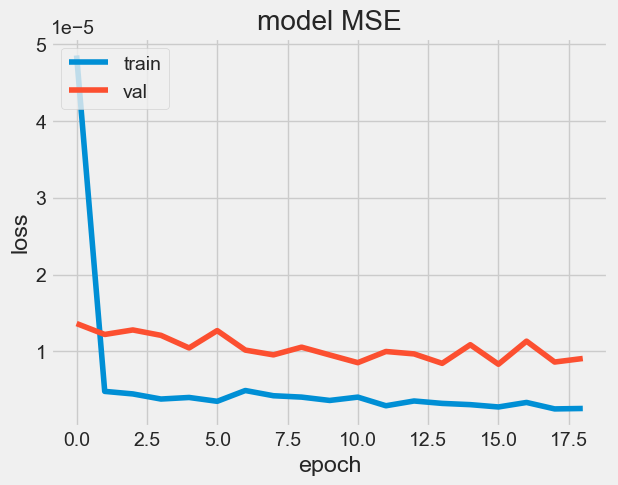

In [257]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

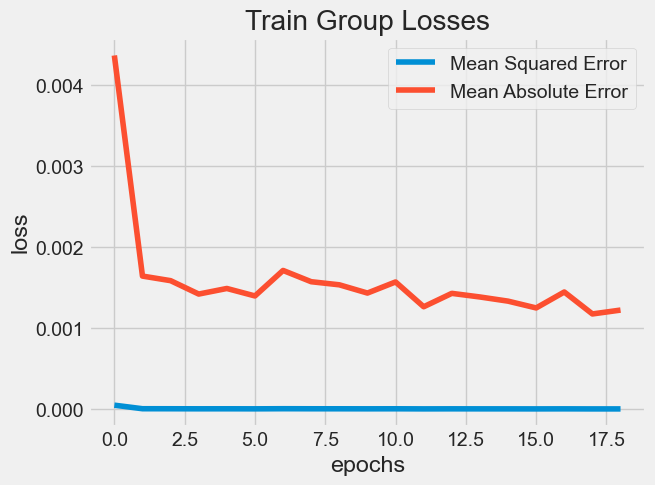

In [258]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Train Group Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [259]:
# Creating a testing set with reference_days time-steps and 1 output
x_test = []
y_test = []

for i in range(reference_days, len(test_data)):
    x_test.append(test_data[i-reference_days:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [260]:
x_test.shape , y_test.shape

((592, 150, 1), (592,))

In [261]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

19/19 [==============================] - 1s 15ms/step


(592, 1)

In [262]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean(y_test - predictions )**2).round(2)


In [263]:
np.mean((y_test - predictions)**2)

189257.5106298224

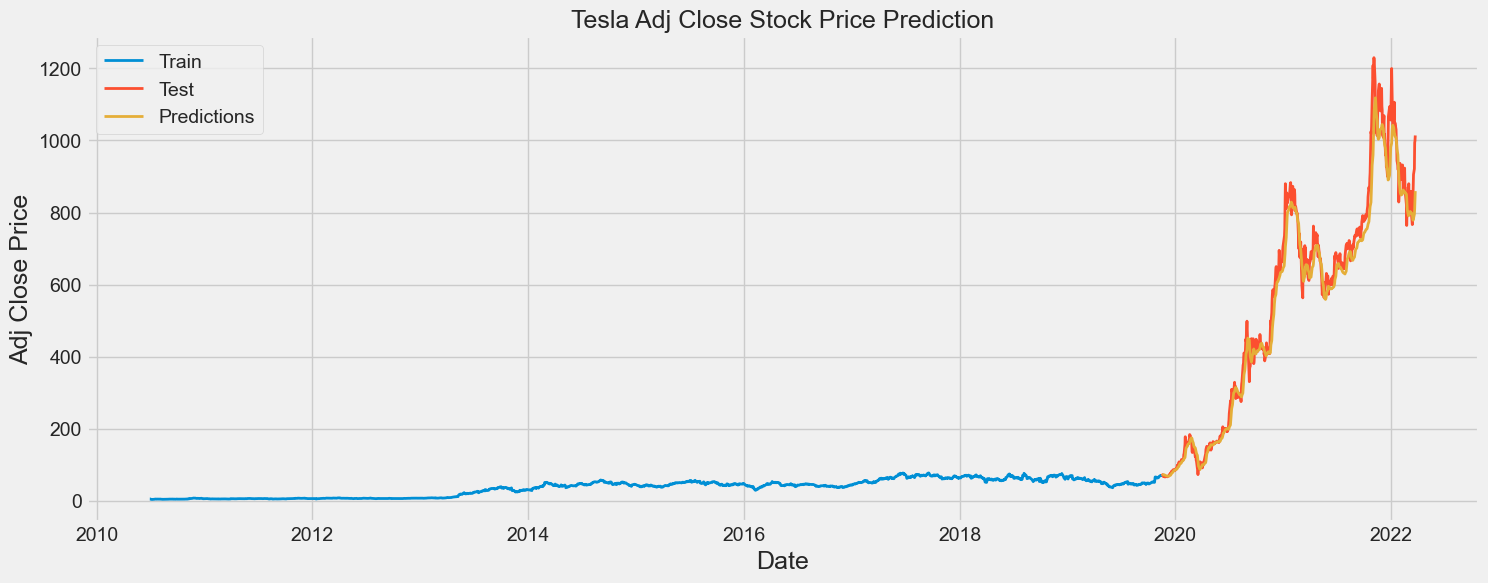

In [264]:
train_val = dataset.iloc[:train_size + val_size , 0:1]
test = dataset.iloc[train_size + val_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Tesla Adj Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Adj Close Price', fontsize= 18)
plt.plot(train_val['Adj Close'], linewidth= 2)
plt.plot(test['Adj Close'], linewidth= 2)
plt.plot(test["Predictions"], linewidth= 2)
plt.legend(['Train', 'Test', 'Predictions'])
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/Tesla data/{model_name}.jpg')

In [265]:
test_data_rolling = scaled_data[train_size + val_size - reference_days: , 0:1 ]

In [266]:
len(test_data_rolling)

742

In [267]:
x_test_rolling = test_data_rolling[:reference_days]

In [268]:
days = len(test_data_rolling) - reference_days

## Multivariate Stock Prediction

In [269]:
path = Path(r'TSLA.csv')
df = pd.read_csv(path,parse_dates= True , index_col= "Date")

In [270]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(df))

In [271]:
# Determining the Training and Testing sizes: 75% and 25% respectively
train_size = int(len(data)*0.65)
val_size = int(len(data)*0.15)
test_size = len(data) - train_size - val_size

print("Train Size :",train_size,"Val Size :",val_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size ,  ]
val_data = scaled_data[ train_size - reference_days :train_size + val_size , ]
test_data = scaled_data[ train_size + val_size - reference_days: , ]

Train Size : 1921 Val Size : 443 Test Size : 592


In [272]:
# Creating a Training set with reference_days time-steps and 1 output
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []
for i in range(reference_days, len(train_data)):
    x_train.append(train_data[i-reference_days:i,: ])
    y_train.append(train_data[i, -1])
for i in range(reference_days, len(val_data)):
    x_val.append(val_data[i-reference_days:i, :])
    y_val.append(val_data[i, -1])
for i in range(reference_days, len(test_data)):
    x_test.append(test_data[i-reference_days:i, :])
    y_test.append(test_data[i, -1])

In [273]:
x_train = np.array(x_train)
y_train = np.array(y_train).reshape((-1,1))

x_val = np.array(x_val)
y_val = np.array(y_val).reshape((-1,1))

x_test = np.array(x_test)
y_test = np.array(y_test).reshape((-1,1))

In [274]:
def create_multivariate_tsa_model(layer_type = 'LSTM', 
                                  learning_rate = 0.01, 
                                  firstlayer_numberofneurons = 50, 
                                  secondlayer_numberofneurons = 64, 
                                  denselayer_numberofneurons = 32):

    if layer_type == 'LSTM':
        model = Sequential([
        LSTM(firstlayer_numberofneurons, return_sequences= True, input_shape= (x_train.shape[1], 6)),
        LSTM(secondlayer_numberofneurons, return_sequences= False),
        Dense(denselayer_numberofneurons),
        Dense(1)
    ])
    if layer_type == 'GRU':
        model = Sequential([
        GRU(firstlayer_numberofneurons, return_sequences= True, input_shape= (x_train.shape[1], 6)),
        GRU(secondlayer_numberofneurons, return_sequences= False),
        Dense(denselayer_numberofneurons),
        Dense(1)
    ])
    if layer_type == 'SimpleRNN':
        model = Sequential([
        SimpleRNN(firstlayer_numberofneurons, return_sequences= True, input_shape= (x_train.shape[1], 6)),
        SimpleRNN(secondlayer_numberofneurons, return_sequences= False),
        Dense(denselayer_numberofneurons),
        Dense(1)
    ])
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss= 'mse' , metrics= "mean_absolute_error", optimizer=opt)
    

    model_name = f'Multivariate_{layer_type}_model_lr{learning_rate}_bs{batch_size}_window_{reference_days}'
    return model_name, model

In [275]:
model_name, model = create_multivariate_tsa_model(layer_type = layer_type, 
                                                  learning_rate = learning_rate, 
                                                  firstlayer_numberofneurons = 50, 
                                                  secondlayer_numberofneurons = 64, 
                                                  denselayer_numberofneurons = 32)

In [276]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 150, 50)           11400     
                                                                 
 lstm_7 (LSTM)               (None, 64)                29440     
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 42,953
Trainable params: 42,953
Non-trainable params: 0
_________________________________________________________________


In [277]:
# Fitting the model to the Training set
callbacks = [EarlyStopping(monitor= 'val_loss', patience= 3 , restore_best_weights= True)]
history = model.fit(x_train, 
                    y_train, 
                    epochs= epochs, 
                    batch_size= batch_size , 
                    validation_data=(x_val, y_val),
                    callbacks= callbacks )

Epoch 1/100
56/56 [==============================] - 4s 36ms/step - loss: 0.0031 - mean_absolute_error: 0.0345 - val_loss: 0.0066 - val_mean_absolute_error: 0.0520
Epoch 2/100
56/56 [==============================] - 1s 24ms/step - loss: 0.0025 - mean_absolute_error: 0.0298 - val_loss: 0.0063 - val_mean_absolute_error: 0.0525
Epoch 3/100
56/56 [==============================] - 1s 24ms/step - loss: 0.0024 - mean_absolute_error: 0.0287 - val_loss: 0.0062 - val_mean_absolute_error: 0.0579
Epoch 4/100
56/56 [==============================] - 1s 24ms/step - loss: 0.0023 - mean_absolute_error: 0.0282 - val_loss: 0.0059 - val_mean_absolute_error: 0.0542
Epoch 5/100
56/56 [==============================] - 1s 25ms/step - loss: 0.0022 - mean_absolute_error: 0.0273 - val_loss: 0.0056 - val_mean_absolute_error: 0.0497
Epoch 6/100
56/56 [==============================] - 1s 25ms/step - loss: 0.0022 - mean_absolute_error: 0.0277 - val_loss: 0.0054 - val_mean_absolute_error: 0.0482
Epoch 7/100
56/5

In [278]:
model.save(f'{model_name}')

INFO:tensorflow:Assets written to: Multivariate_LSTM_model_lr0.001_bs32_window_150\assets


INFO:tensorflow:Assets written to: Multivariate_LSTM_model_lr0.001_bs32_window_150\assets


In [279]:
predictions.shape

(592, 1)

In [280]:
# Inverse y_test scaling
predictions = model.predict(x_test)
# As we used 6 variables to transform, we need to make it up to 6 to transform it back and discard unnecessay columns.
predictions = np.repeat(predictions, df.shape[1], axis = -1)
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions = predictions[:,-1]

19/19 [==============================] - 1s 18ms/step


In [281]:
# Inverse y_test scaling

y_test = np.repeat(y_test, df.shape[1], axis = -1)
y_test = scaler.inverse_transform(y_test)
y_test = y_test[:,-1]

RMSE = np.sqrt(np.mean(y_test - predictions )**2).round(2)

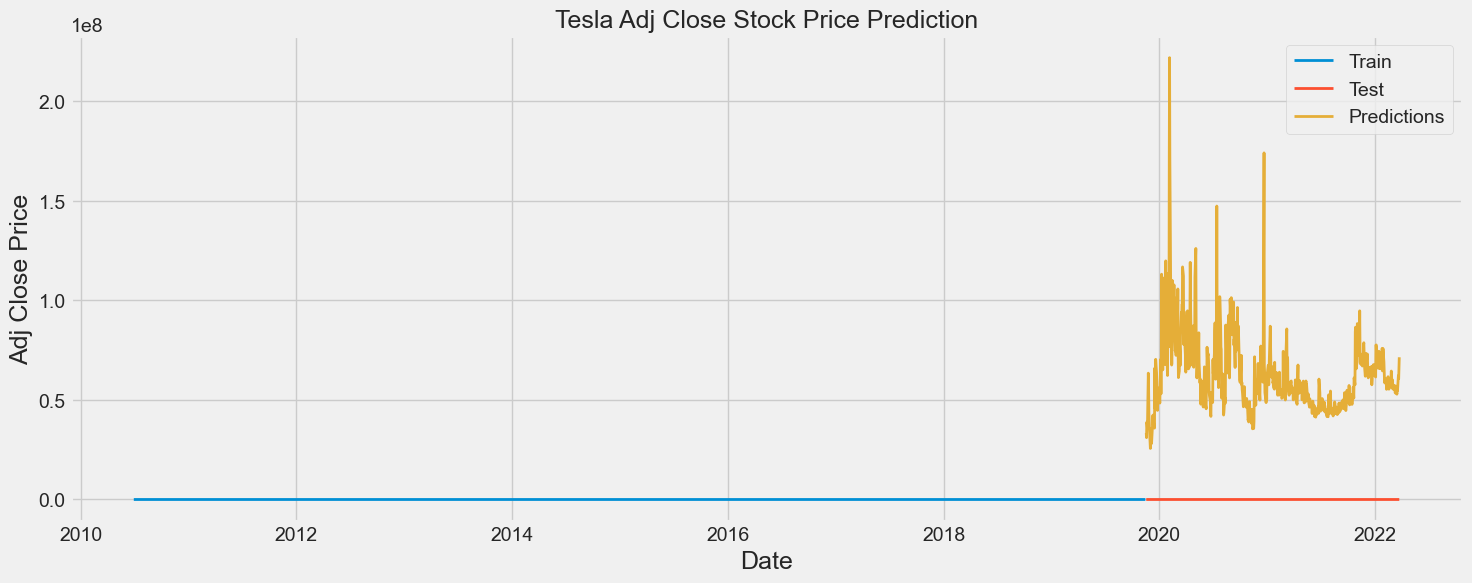

In [282]:
train_val = dataset.iloc[:train_size + val_size , 0:1]
test = dataset.iloc[train_size + val_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Tesla Adj Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Adj Close Price', fontsize= 18)
plt.plot(train_val['Adj Close'], linewidth= 2)
plt.plot(test['Adj Close'], linewidth= 2)
plt.plot(test["Predictions"], linewidth= 2)
plt.legend(['Train', 'Test', 'Predictions'])
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/Tesla data/{model_name}.jpg')

In [283]:
len(test.index.tolist())

592

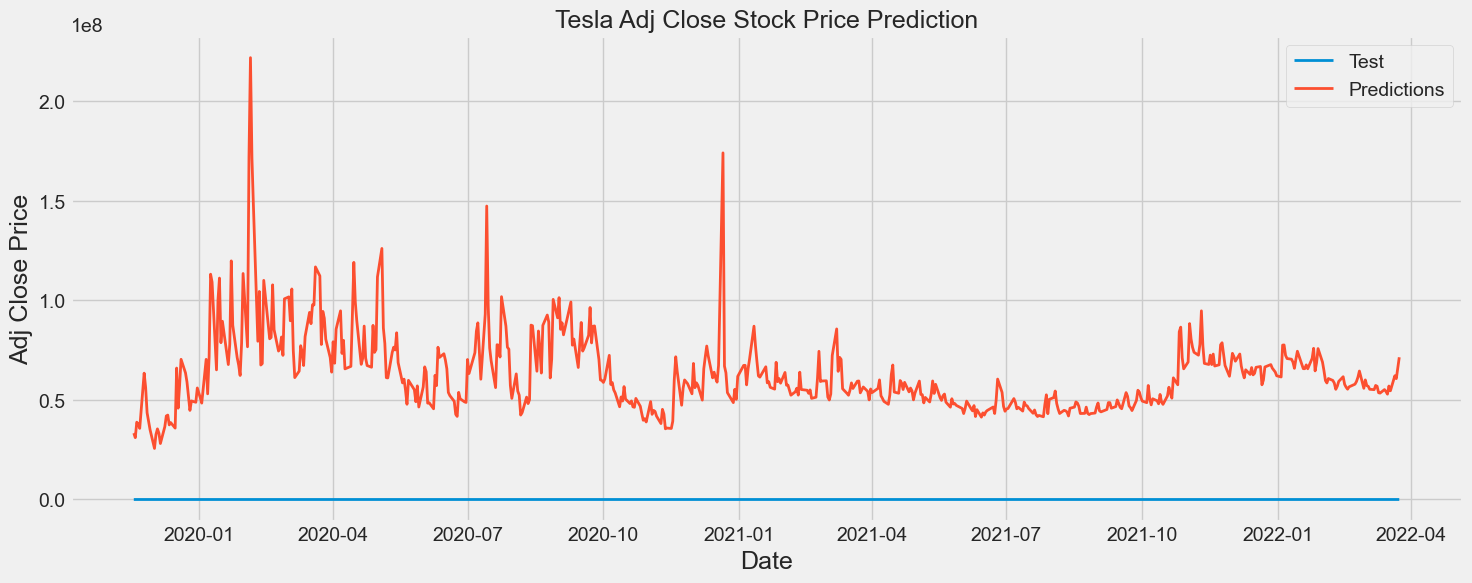

In [284]:
plt.figure(figsize= (16, 6))
plt.title('Tesla Adj Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Adj Close Price', fontsize= 18)
plt.plot(test['Adj Close'], linewidth= 2)
plt.plot(test["Predictions"], linewidth= 2)
plt.legend(['Test', 'Predictions'])

#Result

In [285]:
MSE_multi = (np.mean((y_test - predictions)**2)).round(2)
MAE_multi = (np.mean(np.abs(y_test - predictions))).round(2)
MAPE_multi = np.mean(np.abs((y_test - predictions))/y_test).round(4)

print(model_name, f':\n\nmodel prediction based on past {reference_days} days')
print(f'\nPrediction the next day MSE: {MSE_multi}')
print(f'\nPrediction the next day MAE: {MAE_multi}')
print(f'\nPrediction the next day MAPE: {MAPE_multi}')

Multivariate_LSTM_model_lr0.001_bs32_window_150 :

model prediction based on past 150 days

Prediction the next day MSE: 942808225811944.0

Prediction the next day MAE: 25367293.35

Prediction the next day MAPE: 0.8407
